In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, LassoLarsCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split

%matplotlib inline

# Data

In [2]:
# Spain, UK, Italy, Germany...
# cc_dict = {
#     'ARG': 'Argentina', 'AUS': 'Australia',  
#     'CHN': 'China',     'CZE': 'Czechia',    
#     'EGY': 'Egypt',     'FIN': 'Finland',
#     'HND': 'Honduras',  'IND': 'India',
#     'JPN': 'Japan',     'NOR': 'Norway',
#     'RUS': 'Russia',    'SWE': 'Sweden',
#     'THA': 'Thailand',  'USA': 'US'
# }

cc_dict = {
    'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
    'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
    'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
    'POL': 'Poland',       'SSD': 'South Sudan', 'SWE': 'Sweden',
    'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
}

# pop_dict = { # 2020 population
#     'ARG': 45195774,   'AUS': 25499884, 
#     'CHN': 1439323776, 'CZE': 10708981,   
#     'EGY': 102334404,  'FIN': 5540720,  
#     'HND': 9904607,    'IND': 1380004385, 
#     'JPN': 126476461,  'NOR': 5421241,  
#     'RUS': 145934462,  'SWE': 10099265,
#     'THA': 69799978,   'USA': 331002651
# }

pop_dict = {
    'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
    'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
    'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
    'POL': 37846611,  'SSD': 11193725, 'SWE': 10099265,
    'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
}

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

In [3]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [4]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 552)

In [5]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 552)

In [6]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 552)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [7]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,5619,5623,5626,5629,5631,5637,5642,5649,5655,5666,5684,5695,5725,5756,5778,5798,5826,5854,5886,5926,5942,5979,5997,6025,6064,6109,6161,6243,6359,6452,6551,6618,6716,6833,6942,7042,7121,7233,7357,7498
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,175,175,175,175,175,176,176,176,176,177,177,177,178,181,181,184,184,185,185,185,185,185,185,185,185,186,188,188,188,189,189,189,190,191,191,191,191,191,191,191
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,1652,1655,1655,1661,1664,1664,1665,1670,1673,1674,1678,1679,1680,1683,1686,1690,1696,1700,1705,1714,1715,1723,1728,1729,1732,1732,1737,1738,1739,1742,1747,1752,1753,1754,1755,1757,1761,1761,1761,1764
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,775,775,776,780,781,784,785,788,788,788,788,792,789,791,794,796,801,807,807,809,810,813,813,813,813,814,816,818,819,821,821,823,825,831,831,832,838,840,846,850
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,20665,20668,20676,20678,20680,20683,20685,20694,20696,20697,20699,20702,20706,20708,20708,20710,20712,20712,20715,20713,20714,20716,20718,20718,20718,20719,20722,20722,20722,20725,20727,20737,20748,20767,20785,20799,20813,20837,20865,20879
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1018,1019,1020,1020,1020,1020,1020,1020,1020,1020,1020,1021,1021,1022,1023,1024,1025,1027,1028,1029,1029,1030,1032,1033,1033,1033,1033,1033,1036,1036,1036,1036,1036,1037,1037,1037,1038,1046,1048,1048


In [8]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11080,11081,11084,11089,11099,11103,11106,11108,11112,11116,11118,11125,11126,11131,11131,11132,11135,11138,11140,11144,11144,11144,11144,11144,11144,11144,11169,11169,11169,11169,11180,11186,11199,11199,11223,11235,11244,11257,11272,11293
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1619,1619,1623,1627,1629,1629,1630,1632,1633,1634,1634,1635,1636,1639,1640,1640,1646,1649,1650,1651,1651,1651,1652,1652,1652,1654,1656,1658,1659,1660,1661,1661,1661,1664,1668,1672,1672,1683,1683,1690
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12295,12296,12296,12304,12308,12314,12317,12318,12319,12321,12322,12327,12327,12330,12330,12332,12339,12342,12343,12345,12349,12349,12349,12350,12354,12364,12371,12380,12389,12395,12418,12453,12537,12605,12699,12775,12804,12883,12962,13038
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2522,2532,2543,2554,2561,2564,2570,2570,2575,2582,2585,2594,2601,2601,2601,2613,2614,2618,2618,2618,2620,2620,2627,2630,2632,2633,2633,2638,2638,2641,2650,2656,2659,2659,2664,2664,2677,2687,2695,2698
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1672744,1673596,1674628,1675644,1676708,1677596,1678282,1678983,1679542,1680228,1680880,1681580,1682221,1682773,1683271,1683828,1684366,1685000,1685825,1686766,1687891,1689106,1690625,1692834,1696480,1701911,1708837,1719120,1728438,1736879,1744700,1755126,1766102,1777399,1788435,1798570,1807444,1814143,1821040,1827273


Canada does not have recovery data available at province-level.

In [9]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Uzbekistan         1
Name: Country/Region, dtype: int64

In [10]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Uzbekistan         1
Name: Country/Region, dtype: int64

In [11]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Morocco            1
Albania            1
Name: Country/Region, dtype: int64

In [12]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 549)
deaths shape: (275, 549)
recoveries shape: (260, 549)


In [13]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (548, 195)
deaths shape: (548, 195)
recoveries shape: (548, 195)


In [14]:
cum_cases = jhu_cases[cc_dict.values()]
cum_cases

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,1103413,81467,337575,283636,1491712,761225,14513,43470,28346,2881424,10917,1094287,2295095,185649,83619
2021-07-19,1107208,81467,337738,283762,1501595,761225,14513,43817,28397,2881491,10917,1094287,2302304,186279,85732
2021-07-20,1108675,81467,337975,283813,1510517,762420,14522,44684,28510,2881594,10917,1095279,2311232,187602,88415
2021-07-21,1108675,81467,338291,283862,1518837,762706,14524,45465,28612,2881718,10917,1095758,2327472,188573,91120


In [15]:
cum_deaths = jhu_death[cc_dict.values()]
cum_deaths

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,25209,1330,3916,16439,17830,9896,530,1338,285,75215,117,14646,66859,3084,2622
2021-07-19,25213,1330,3916,16452,17892,9896,530,1352,285,75215,117,14646,67080,3113,2697
2021-07-20,25213,1330,3928,16457,17951,9916,530,1363,286,75219,117,14650,67676,3138,2747
2021-07-21,25213,1330,3929,16465,18020,9922,530,1389,286,75222,117,14651,68192,3162,2809


In [16]:
cum_recoveries = jhu_recov[cc_dict.values()]
cum_recoveries

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0,35261,279714,223213,1356267,743296,11870,34922,27524,2652984,10514,0,2050164,171699,53453
2021-07-19,0,35261,280241,224299,1364545,743296,11870,35087,27538,2653034,10514,0,2069085,173320,55714
2021-07-20,0,35261,280645,225068,1372158,744365,12376,35203,27563,2652994,10514,0,2085119,174728,58155
2021-07-21,0,35261,282841,225869,1379074,745005,12626,35432,27585,2653025,10514,0,2098818,175429,59627


In [17]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [18]:
R = cum_deaths + cum_recoveries
R

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,25209,36591,283630,239652,1374097,753192,12400,36260,27809,2728199,10631,14646,2117023,174783,56075
2021-07-19,25213,36591,284157,240751,1382437,753192,12400,36439,27823,2728249,10631,14646,2136165,176433,58411
2021-07-20,25213,36591,284573,241525,1390109,754281,12906,36566,27849,2728213,10631,14650,2152795,177866,60902
2021-07-21,25213,36591,286770,242334,1397094,754927,13156,36821,27871,2728247,10631,14651,2167010,178591,62436


In [19]:
I = cum_cases - R
I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,1078204,44876,53945,43984,117615,8033,2113,7210,537,153225,286,1079641,178072,10866,27544
2021-07-19,1081995,44876,53581,43011,119158,8033,2113,7378,574,153242,286,1079641,166139,9846,27321
2021-07-20,1083462,44876,53402,42288,120408,8139,1616,8118,661,153381,286,1080629,158437,9736,27513
2021-07-21,1083462,44876,51521,41528,121743,7779,1368,8644,741,153471,286,1081107,160462,9982,28684


In [20]:
S = pop_dict.values() - cum_cases
S

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,10099265,59308690,18383955,14862924
2020-01-23,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,10099265,59308690,18383955,14862924
2020-01-24,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,10099265,59308690,18383955,14862924
2020-01-25,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,10099265,59308690,18383955,14862924
2020-01-26,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,10099265,59308690,18383955,14862924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,10486210,26464396,10510335,102050768,38730781,9441909,20236320,19086482,17106526,34965187,11182808,9004978,57013595,18198306,14779305
2021-07-19,10482415,26464396,10510172,102050642,38720898,9441909,20236320,19086135,17106475,34965120,11182808,9004978,57006386,18197676,14777192
2021-07-20,10480948,26464396,10509935,102050591,38711976,9440714,20236311,19085268,17106362,34965017,11182808,9003986,56997458,18196353,14774509
2021-07-21,10480948,26464396,10509619,102050542,38703656,9440428,20236309,19084487,17106260,34964893,11182808,9003507,56981218,18195382,14771804


### Initial approximation

In [21]:
i_prop = I / pop_dict.values()
i_prop

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.093032,0.001691,0.004973,0.000430,0.002924,0.000787,0.000104,0.000377,0.000031,0.004049,0.000026,0.106903,0.003002,0.000591,0.001853
2021-07-19,0.093359,0.001691,0.004939,0.000420,0.002962,0.000787,0.000104,0.000386,0.000033,0.004049,0.000026,0.106903,0.002801,0.000536,0.001838
2021-07-20,0.093486,0.001691,0.004923,0.000413,0.002994,0.000798,0.000080,0.000424,0.000039,0.004053,0.000026,0.107001,0.002671,0.000530,0.001851
2021-07-21,0.093486,0.001691,0.004749,0.000406,0.003027,0.000762,0.000068,0.000452,0.000043,0.004055,0.000026,0.107048,0.002706,0.000543,0.001930


In [22]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,-2.374813,-6.382726,-5.303763,-7.752175,-5.834765,-7.146892,-9.167842,-7.883542,-10.370628,-5.509389,-10.574872,-2.235834,-5.808323,-7.433595,-6.290840
2021-07-19,-2.371304,-6.382726,-5.310533,-7.774545,-5.821731,-7.146892,-9.167842,-7.860508,-10.303997,-5.509278,-10.574872,-2.235834,-5.877686,-7.532168,-6.298969
2021-07-20,-2.369949,-6.382726,-5.313880,-7.791498,-5.811296,-7.133783,-9.435997,-7.764927,-10.162872,-5.508372,-10.574872,-2.234919,-5.925154,-7.543403,-6.291966
2021-07-21,-2.369949,-6.382726,-5.349738,-7.809633,-5.800269,-7.179022,-9.602601,-7.702145,-10.048626,-5.507785,-10.574872,-2.234477,-5.912454,-7.518450,-6.250286


In [23]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.000000,0.000000,-0.010694,0.000000,0.005910,0.012527,-0.088706,0.033997,0.181205,0.000215,0.0,0.000000,-0.055971,-0.123961,-0.020056
2021-07-19,0.003510,0.000000,-0.006770,-0.022370,0.013034,0.000000,0.000000,0.023034,0.066631,0.000111,0.0,0.000000,-0.069363,-0.098573,-0.008129
2021-07-20,0.001355,0.000000,-0.003346,-0.016953,0.010436,0.013109,-0.268155,0.095581,0.141124,0.000907,0.0,0.000915,-0.047468,-0.011235,0.007003
2021-07-21,0.000000,0.000000,-0.035859,-0.018135,0.011026,-0.045240,-0.166604,0.062782,0.114247,0.000587,0.0,0.000442,0.012700,0.024953,0.041681


### Transmission coefficient computation

In [24]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_I = np.log(I)
warnings.resetwarnings()
# before the pandemic begins
log_I[np.isinf(log_I)] = 0
log_I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,13.890807,10.711658,10.895720,10.691581,11.675172,8.991313,7.655864,8.883224,6.285998,11.939663,5.655992,13.892139,12.089943,9.293394,10.223540
2021-07-19,13.894317,10.711658,10.888950,10.669211,11.688206,8.991313,7.655864,8.906258,6.352629,11.939774,5.655992,13.892139,12.020580,9.194821,10.215411
2021-07-20,13.895672,10.711658,10.885603,10.652259,11.698641,9.004423,7.387709,9.001839,6.493754,11.940680,5.655992,13.893054,11.973112,9.183586,10.222414
2021-07-21,13.895672,10.711658,10.849745,10.634123,11.709668,8.959183,7.221105,9.064621,6.608001,11.941267,5.655992,13.893496,11.985812,9.208539,10.264095


In [25]:
log_diff = log_I[1:] - log_I[:-1].values # different index
log_diff

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.000000,0.000000,-0.010694,0.000000,0.005910,0.012527,-0.088706,0.033997,0.181205,0.000215,0.0,0.000000,-0.055971,-0.123961,-0.020056
2021-07-19,0.003510,0.000000,-0.006770,-0.022370,0.013034,0.000000,0.000000,0.023034,0.066631,0.000111,0.0,0.000000,-0.069363,-0.098573,-0.008129
2021-07-20,0.001355,0.000000,-0.003346,-0.016953,0.010436,0.013109,-0.268155,0.095581,0.141124,0.000907,0.0,0.000915,-0.047468,-0.011235,0.007003
2021-07-21,0.000000,0.000000,-0.035859,-0.018135,0.011026,-0.045240,-0.166604,0.062782,0.114247,0.000587,0.0,0.000442,0.012700,0.024953,0.041681


In [26]:
dR_dt = R[1:] - R[:-1].values # different index
dR_dt

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0,0,1008,0,8005,575,200,186,3,36,0,0,21466,2411,1564
2021-07-19,4,0,527,1099,8340,0,0,179,14,50,0,0,19142,1650,2336
2021-07-20,0,0,416,774,7672,1089,506,127,26,-36,0,4,16630,1433,2491
2021-07-21,0,0,2197,809,6985,646,250,255,22,34,0,1,14215,725,1534


In [27]:
# to do: decide on infinite values
gamma = dR_dt / I[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.000000,0.000000,0.018686,0.000000,0.068061,0.071580,0.094652,0.025798,0.005587,0.000235,0.0,0.000000e+00,0.120547,0.221885,0.056782
2021-07-19,0.000004,0.000000,0.009836,0.025552,0.069991,0.000000,0.000000,0.024261,0.024390,0.000326,0.0,0.000000e+00,0.115217,0.167581,0.085502
2021-07-20,0.000000,0.000000,0.007790,0.018303,0.063717,0.133800,0.313119,0.015644,0.039334,-0.000235,0.0,3.701548e-06,0.104963,0.147186,0.090539
2021-07-21,0.000000,0.000000,0.042643,0.019481,0.057375,0.083044,0.182749,0.029500,0.029690,0.000222,0.0,9.249778e-07,0.088588,0.072631,0.053479


In [28]:
beta = (log_diff + gamma) / S[1:]
beta

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.000000e+00,0.000000e+00,7.603369e-10,0.000000e+00,1.909865e-09,8.907787e-09,2.938460e-10,3.132830e-09,1.091931e-08,1.287971e-11,0.0,0.000000e+00,1.132644e-09,5.380949e-09,2.484951e-09
2021-07-19,3.351863e-10,0.000000e+00,2.916313e-10,3.117637e-11,2.144188e-09,0.000000e+00,0.000000e+00,2.477975e-09,5.320883e-09,1.250455e-11,0.0,0.000000e+00,8.043590e-10,3.792098e-09,5.235968e-09
2021-07-20,1.292737e-10,0.000000e+00,4.228039e-10,1.323388e-11,1.915488e-09,1.556127e-08,2.221948e-09,5.827818e-09,1.054922e-08,1.921753e-11,0.0,1.019995e-10,1.008731e-09,7.471320e-09,6.602047e-09
2021-07-21,0.000000e+00,0.000000e+00,6.455133e-10,1.318340e-11,1.767307e-09,4.004539e-09,7.977936e-10,4.835438e-09,8.414253e-09,2.311296e-11,0.0,4.922106e-11,1.777569e-09,5.363111e-09,6.442013e-09


### Curve smoothing

In [29]:
window = 5

In [30]:
gr_smooth = gr.rolling(window, min_periods=1, center=True).mean()
gr_smooth

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,0.001222,0.002706,-0.005209,-0.014857,0.007039,0.009821,-0.109933,0.073764,0.173947,0.000099,0.0,0.000250,-0.051673,-0.053940,0.006149
2021-07-19,0.000973,0.000000,-0.012358,-0.015262,0.008408,0.000335,-0.143682,0.064665,0.155224,0.000232,0.0,0.000271,-0.037277,-0.041275,0.008365
2021-07-20,0.001615,0.001784,-0.028159,-0.014534,0.009339,-0.007894,-0.143096,0.055872,0.117954,0.000429,0.0,0.000379,-0.027799,-0.059914,0.005101
2021-07-21,0.002018,0.002230,-0.032526,-0.018168,0.010196,-0.012999,-0.156694,0.061341,0.102141,0.000482,0.0,0.000474,-0.020756,-0.043902,0.011391


In [31]:
beta_smooth = beta.rolling(window, min_periods=1, center=True).mean()
beta_smooth

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Sweden,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,1.166812e-10,1.032468e-10,6.442441e-10,1.592951e-11,1.922380e-09,7.232670e-09,7.548984e-10,4.858397e-09,1.174073e-08,1.653645e-11,2.332649e-23,2.788920e-11,1.159505e-09,5.611721e-09,4.698986e-09
2021-07-19,9.289200e-11,5.314635e-24,5.827439e-10,1.494360e-11,1.907196e-09,6.738086e-09,8.933015e-10,4.500024e-09,1.075337e-08,1.780078e-11,2.332649e-23,3.024411e-11,1.219668e-09,5.588031e-09,4.851840e-09
2021-07-20,1.542103e-10,6.773207e-11,7.388371e-10,1.385499e-11,1.889451e-09,6.810198e-09,8.834243e-10,4.358515e-09,8.631580e-09,1.808885e-11,2.332649e-23,4.222059e-11,1.263735e-09,5.844534e-09,5.234017e-09
2021-07-21,1.927628e-10,8.466508e-11,7.334621e-10,1.731873e-11,1.884348e-09,6.285800e-09,1.030819e-09,4.664937e-09,8.059648e-09,1.939114e-11,2.915812e-23,5.277574e-11,1.296507e-09,5.960431e-09,5.921284e-09


## Policy

For now, only containment-related policies are considered. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Health system policies also could have great impact; especially information campaign (H1) and regulation of masks (H6).

In [32]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True) # region information
oxcgrt.drop(oxcgrt.columns[19:], axis=1, inplace=True)    # indexes & indicators

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']    # only national status

oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106020 entries, 0 to 177839
Data columns (total 19 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   CountryName                           106020 non-null  object        
 1   CountryCode                           106020 non-null  object        
 2   Jurisdiction                          106020 non-null  object        
 3   Date                                  106020 non-null  datetime64[ns]
 4   C1_School closing                     103605 non-null  float64       
 5   C1_Flag                               80829 non-null   float64       
 6   C2_Workplace closing                  103559 non-null  float64       
 7   C2_Flag                               75263 non-null   float64       
 8   C3_Cancel public events               103603 non-null  float64       
 9   C3_Flag                               81125 non-null   floa

The Oxford dataset contains earlier dates compared to the JHU dataset.

In [33]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-07-22 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-07-23 00:00:00


In [34]:
idc = oxcgrt.columns[4::2]
 
C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idc[7])

CX = [C1, C2, C3, C4, C5, C6, C7, C8]
 
idc

Index(['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls'],
      dtype='object')

In [35]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 125
 - C2: 133
 - C3: 124
 - C4: 124
 - C5: 124
 - C6: 125
 - C7: 125
 - C8: 130


## Visualizations

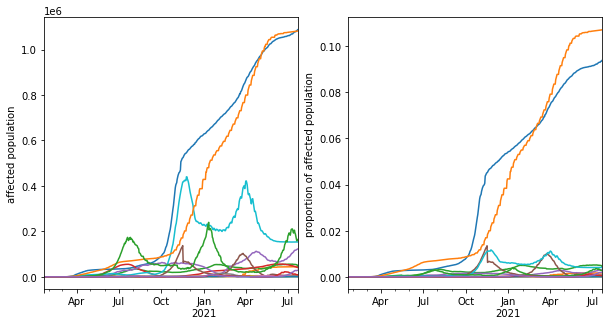

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
I.plot(legend=False, ax=axs[0])
axs[0].set_ylabel('affected population')
i_prop.plot(legend=False, ax=axs[1])
axs[1].set_ylabel('proportion of affected population')
plt.show()

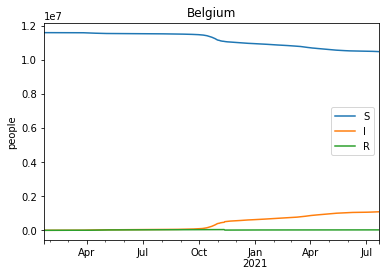

In [37]:
cc_idx = 0
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

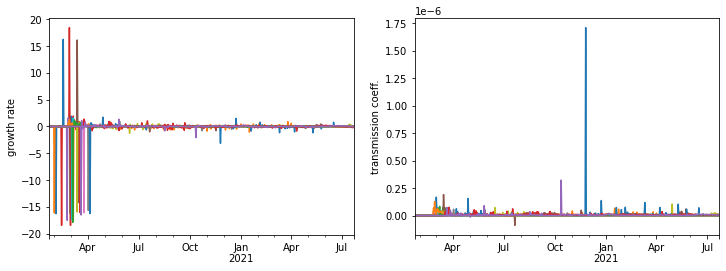

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries (Andorra, San Marino) present various spikes.

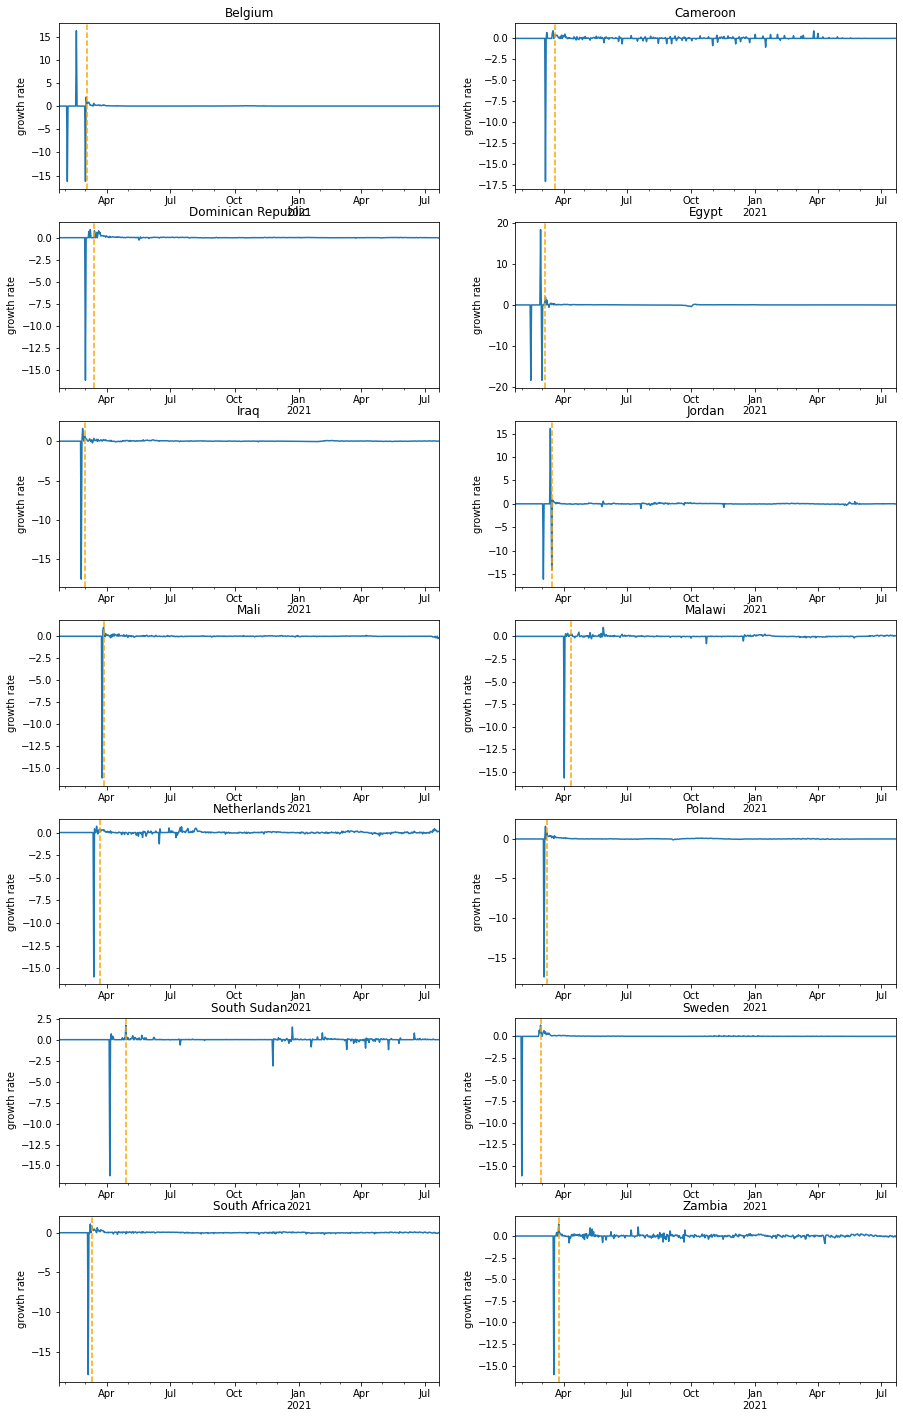

In [39]:
nrows = len(cc_dict) // 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

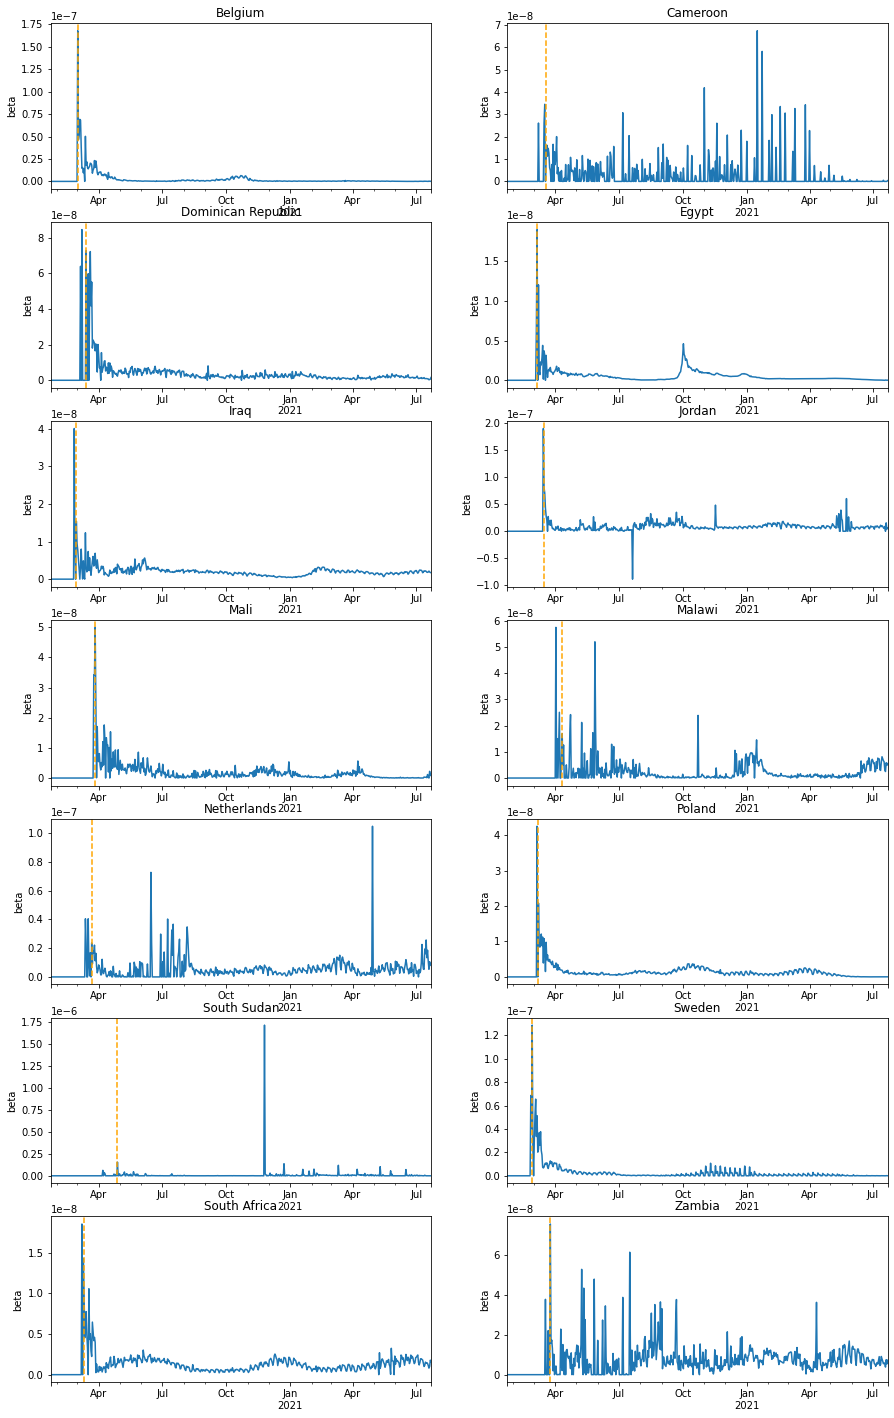

In [40]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

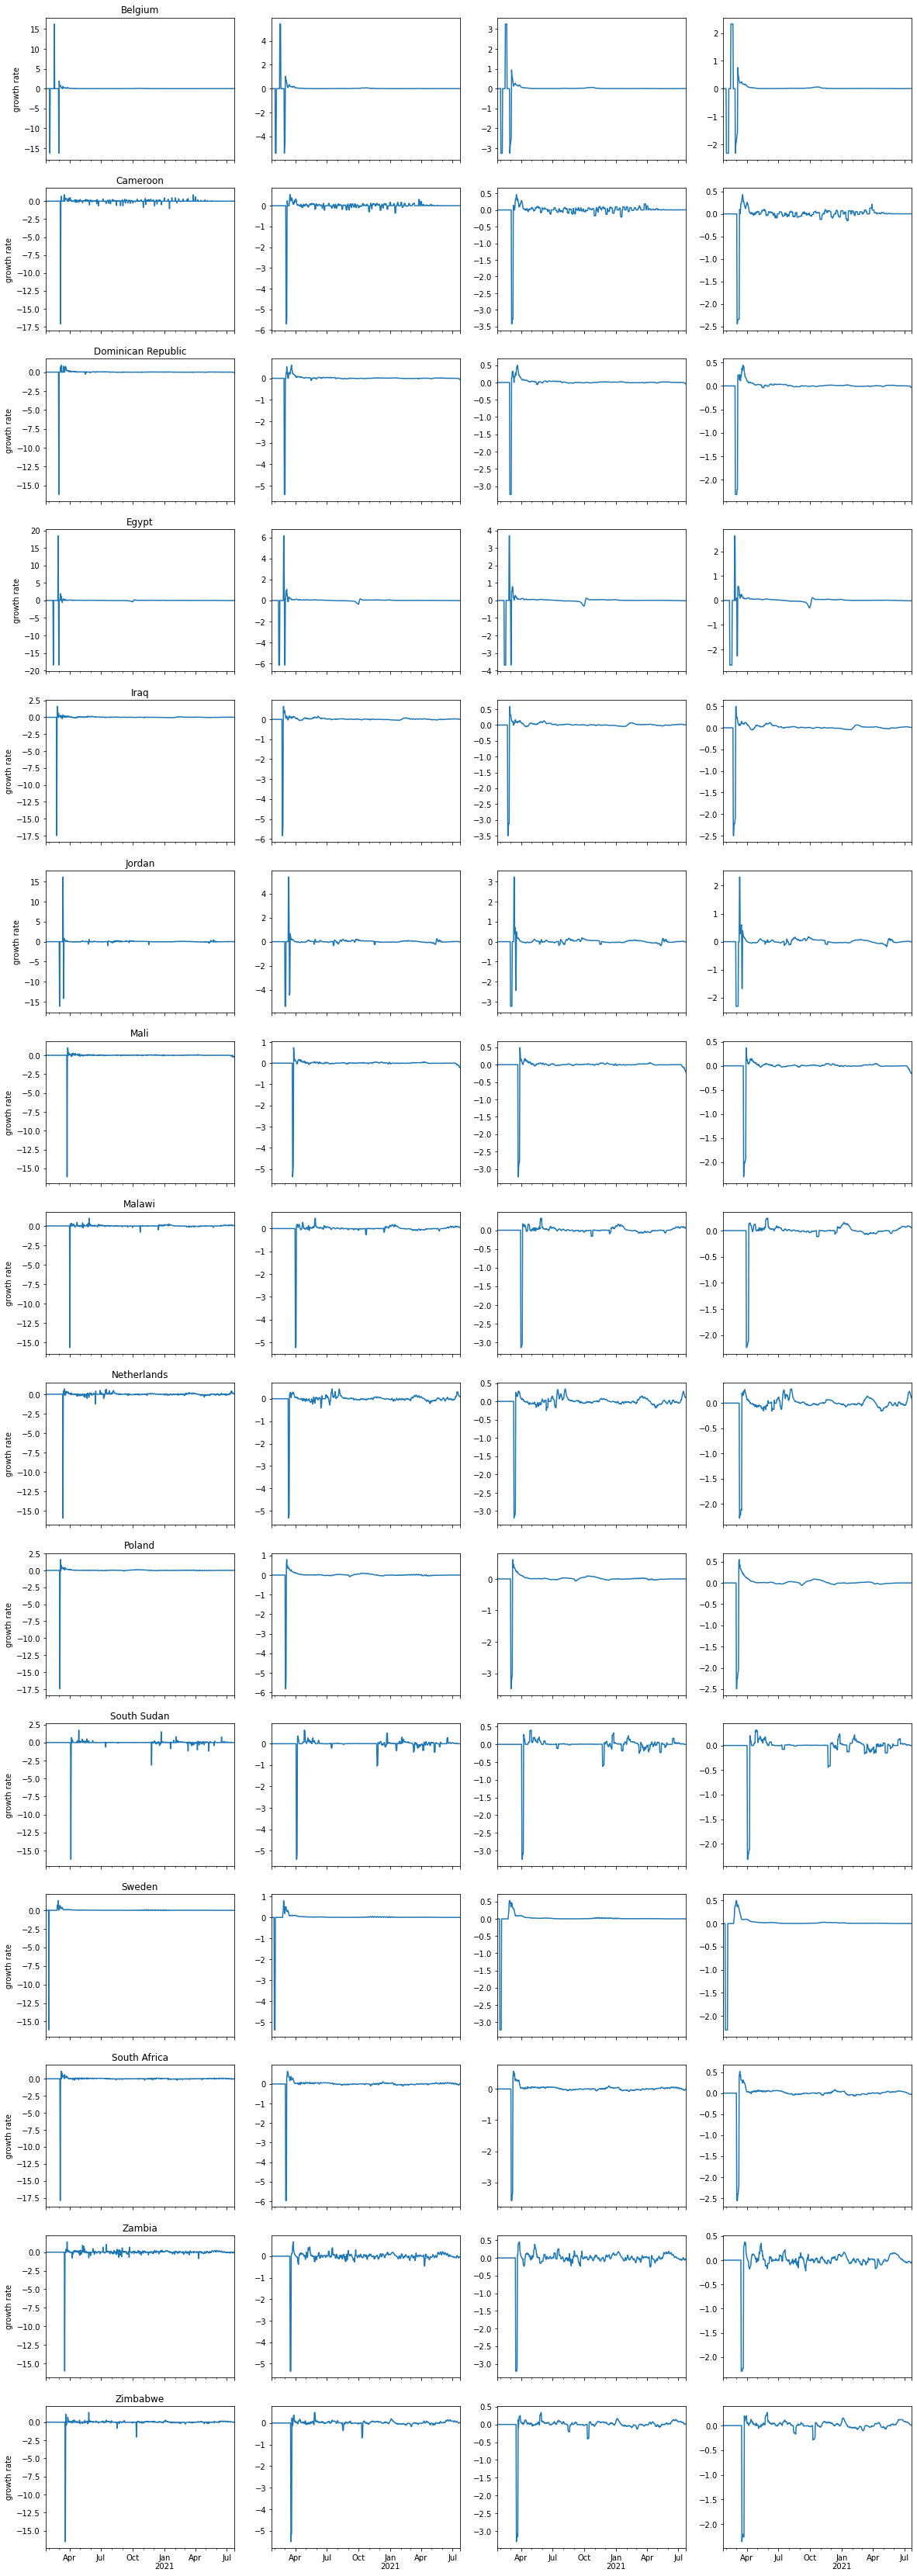

In [41]:
nrows = len(cc_dict)
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 60))
for i in range(nrows):
  cname = list(cc_dict.values())[i]
  gr[cname].plot(ax=axs[i, 0])
  gr[cname].rolling(3, min_periods=1, center=True).mean().plot(ax=axs[i, 1])
  gr[cname].rolling(5, min_periods=1, center=True).mean().plot(ax=axs[i, 2])
  gr[cname].rolling(7, min_periods=1, center=True).mean().plot(ax=axs[i, 3])
  axs[i, 0].set_title(cname)
  axs[i, 0].set_ylabel('growth rate')

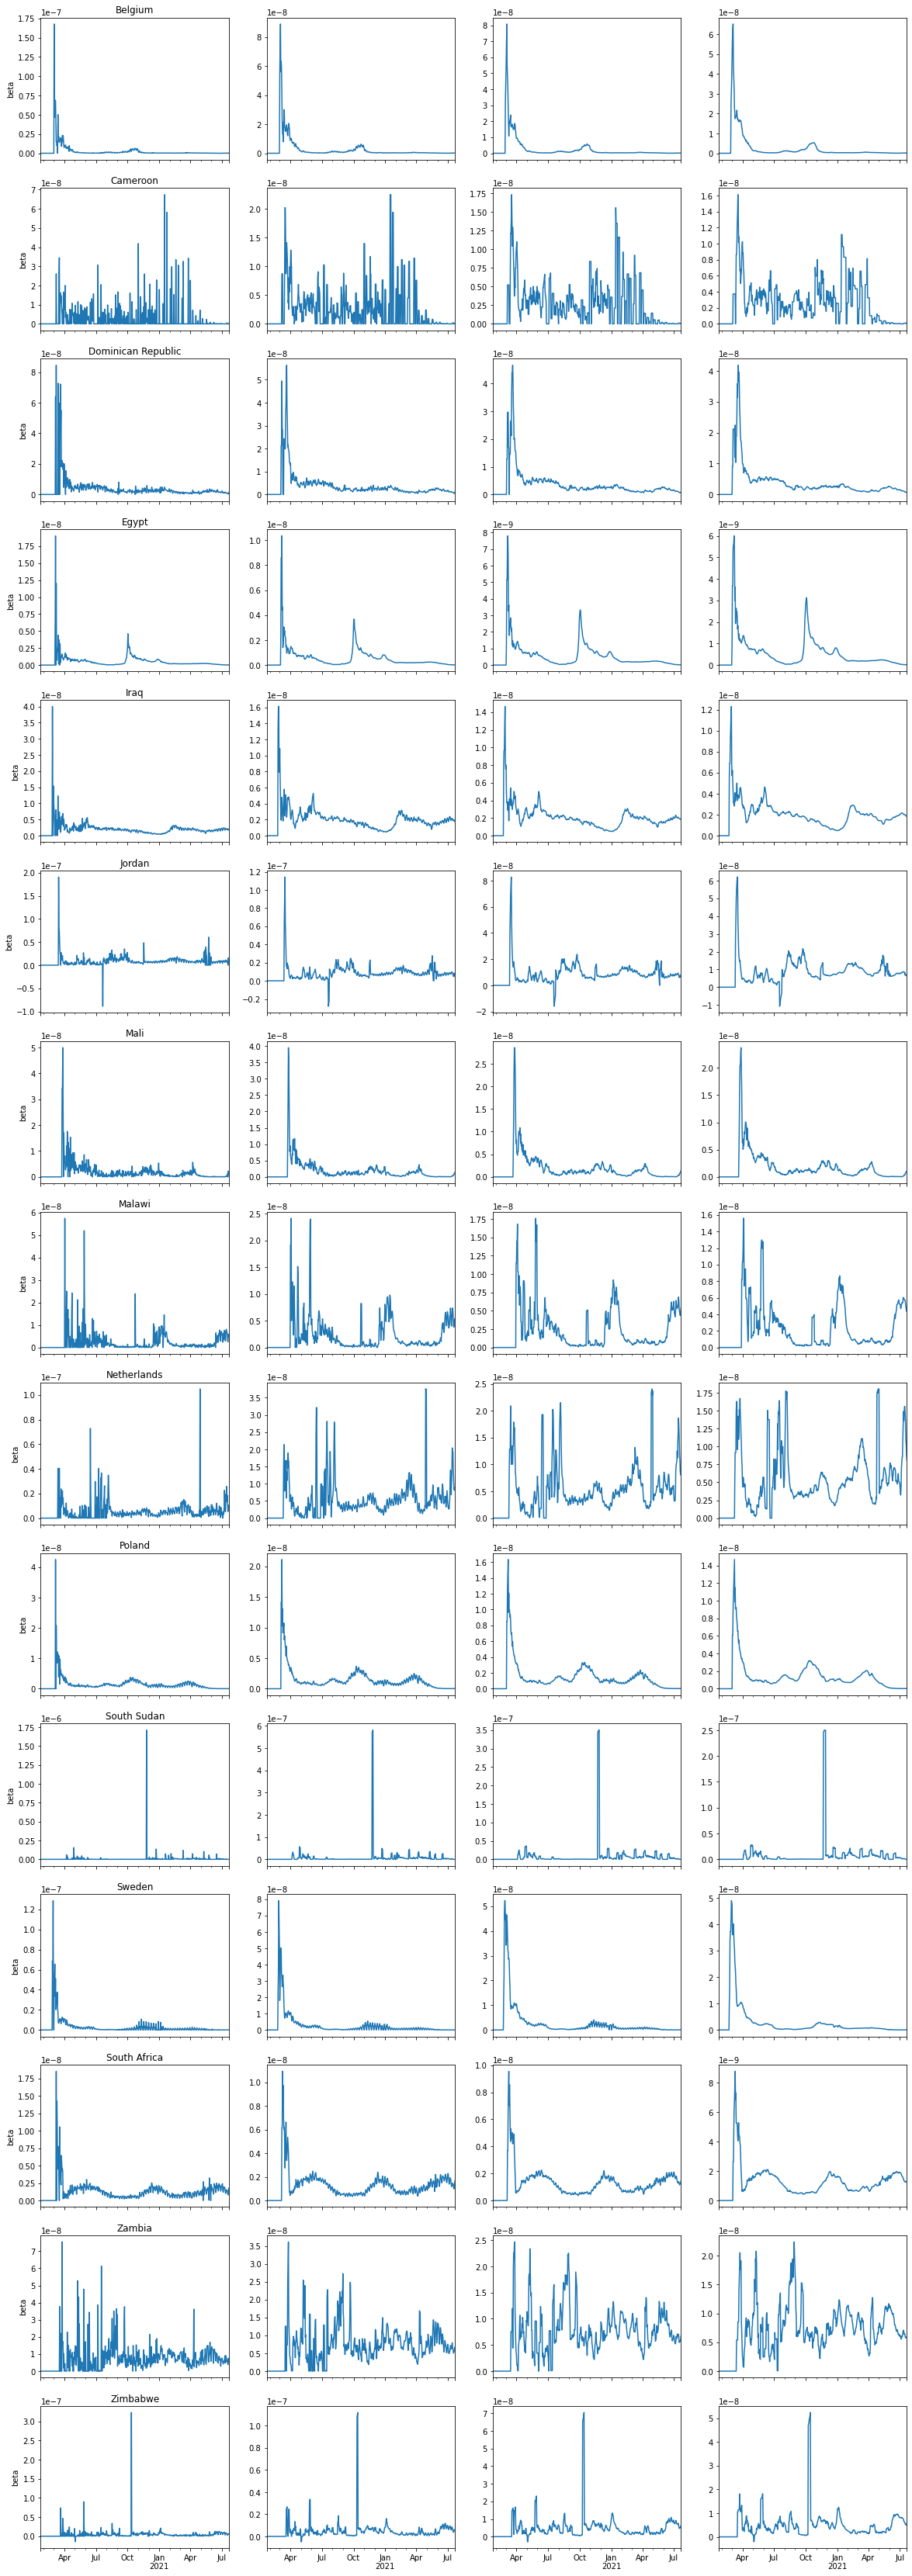

In [42]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 60))
for i in range(nrows):
  cname = list(cc_dict.values())[i]
  beta[cname].plot(ax=axs[i, 0])
  beta[cname].rolling(3, min_periods=1, center=True).mean().plot(ax=axs[i, 1])
  beta[cname].rolling(5, min_periods=1, center=True).mean().plot(ax=axs[i, 2])
  beta[cname].rolling(7, min_periods=1, center=True).mean().plot(ax=axs[i, 3])
  axs[i, 0].set_title(cname)
  axs[i, 0].set_ylabel('beta')

# Model

## Auxiliar

In [43]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

cx_str = [s.split('_')[0] for s in idc]

In [44]:
ta == beta.index.min()

True

In [45]:
# aux fns
def data_from(iso, t0, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = cum_cases.loc[cum_cases[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases[name] / pop_dict[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  cx = [c.loc[t0 - delay:t1 - delay, iso] for c in CX]
  pol_t = pd.concat(cx, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: drop redundant policy combinations vars
# to do: add day-of-the-week info
def preprocess(pol_t, y_t, degree=1):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_scaled = minmax_scale(pol_t[1:])
  # policy combinations
  poly = PolynomialFeatures(degree=degree, interaction_only=True)
  pol_comb = poly.fit_transform(pol_scaled)
  comb_str = poly.get_feature_names(cx_str)

  # group data
  td1 = y_t[:-1].values.reshape(-1, 1)
  arr = np.hstack([pol_comb, td1])
  col = np.append(comb_str, 'last')
  df = pd.DataFrame(arr, columns=col)
  
  return df, y_t[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(score)

## Initial model

In [46]:
def initial_model(region, tr=1, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, tr, delay, gr_smooth)
  X, y = preprocess(X_raw, y_raw, degree=8)
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=1), max_iter=7*10**4)
  reg = lasso.fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Customized grid of values for the parameters. 

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it is used for the CV loop. However, the general accuracy obtained is lower, therefore, it is not used when fitting the model.

In [47]:
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw, degree=8)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.41211114, 0.5913238 , 0.63974957, 0.62207938, 0.65314812,
       0.52983144, 0.62546556, 0.62305683, 0.61514488, 0.60011517,
       0.53540275, 0.5260349 , 0.57035574, 0.6105772 , 0.60410668,
       0.44008238, 0.61487758, 0.57011436, 0.67917492, 0.64212811,
       0.51244825, 0.58844494, 0.65191614, 0.64045872, 0.61088281])

In [48]:
cv_arr.mean()

0.5883612543342235

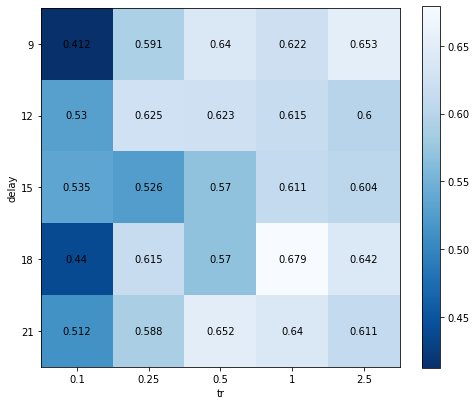

In [49]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

Performance ($R^2$) for the chosen parameteres.

In [50]:
[round(initial_model(k)[3], 3) for k in cc_dict.keys()]

[0.97,
 0.67,
 0.97,
 0.81,
 0.888,
 0.268,
 0.901,
 0.845,
 0.864,
 0.991,
 0.662,
 0.977,
 0.953,
 0.752,
 0.768]

In [51]:
idx = 6 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.003295
C4 : 0.013430
C6 : -0.003859
C7 : -0.000118
C1 C2 : 0.002891
C1 C6 : -0.000535
C1 C7 : -0.000154
C2 C6 : 0.001604
C3 C4 : 0.000275
C3 C6 : -0.001044
C4 C6 : -0.000004
C4 C8 : 0.000519
C6 C8 : 0.003398
C1 C2 C3 : 0.000263
C1 C2 C4 : 0.000324
C1 C3 C6 : -0.002684
C1 C3 C7 : -0.000125
C1 C4 C6 : -0.000040
C1 C4 C7 : -0.000062
C1 C6 C7 : -0.000000
C1 C6 C8 : 0.002850
C2 C4 C6 : 0.000043
C2 C6 C8 : 0.005395
C3 C4 C6 : -0.002632
C3 C4 C7 : -0.002007
C3 C6 C7 : -0.000503
C3 C6 C8 : 0.001597
C3 C7 C8 : -0.000492
C4 C6 C8 : 0.000413
C4 C7 C8 : -0.000399
C6 C7 C8 : -0.000000
C1 C2 C4 C6 : 0.000279
C1 C2 C6 C8 : 0.005038
C1 C3 C4 C6 : -0.004775
C1 C3 C4 C7 : -0.001175
C1 C3 C6 C7 : -0.000470
C1 C3 C6 C8 : 0.002665
C1 C3 C7 C8 : -0.000064
C1 C4 C6 C7 : -0.000000
C2 C3 C4 C6 : 0.002302
C2 C3 C6 C8 : 0.003782
C2 C4 C6 C8 : 0.000000
C3 C4 C6 C7 : -0.003512
C3 C4 C7 C8 : -0.000080
C3 C6 C7 C8 : -0.000000
C1 C2 C3 C6 C8 : 0.004761
C1 C3 C4 C6 C7 : -0.003057
C1 C

In [52]:
for i in idc:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls


Overfitting

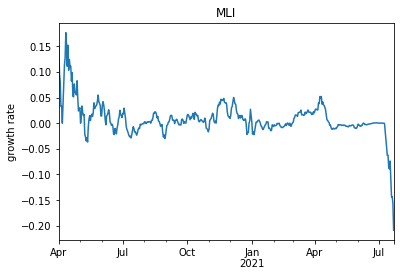

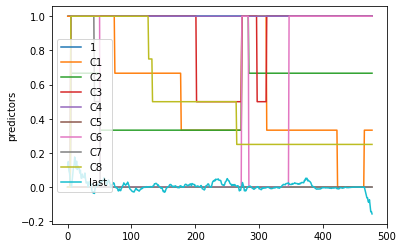


Number of data points: 478
Number of variables: 10


In [53]:
p_t, g_t = data_from(cci, None, 0.5, 12, gr_smooth)
p_t, g_t = preprocess(p_t, g_t, degree=1)

g_t.plot()
plt.ylabel('growth rate')
plt.title(cci)
p_t.plot(legend=True)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', p_t.shape[0])
print('Number of variables:', p_t.shape[1])

Growth rate for every country of interest.

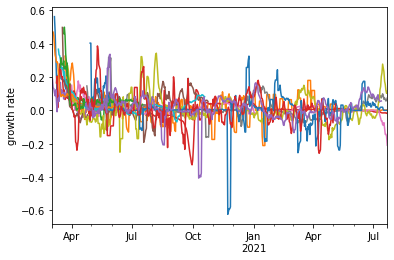

In [54]:
for cc in cc_dict:
  p_t, g_t = data_from(cc, t0=None, tr=0.5, t_d=18, y=gr_smooth)
  p_t, g_t = preprocess(p_t, g_t)
  g_t.plot()
plt.ylabel('growth rate')
plt.show()

## Transmission analysis

In [ ]:
def linear_model(region, t0=None, tr=5, delay=18, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - t0 (str) : beginning of time frame.
  - tr (float) : percentage treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, t0, tr, delay, beta_smooth)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values

  reg = LinearRegression().fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Parameter grid search.

In [ ]:
y_df = beta_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [7, 10, 14, 18, 21]}
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
lasso = LassoCV(cv=KFold(shuffle=True, random_state=9), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw, degree=8)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

In [ ]:
cv_arr = []
grid = {'tr': [0.25, 0.5, 1, 2, 5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()

for par in list(ParameterGrid(grid)):
  cv_par = [linear_model(k, None, par['tr'], par['delay'])[3] for k in cc_dict.keys()]
  cv_arr.append(cv_par)
cv_arr = np.asarray(cv_arr).mean(axis=1) # country axis
cv_arr

In [ ]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r')
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

Performance ($R^2$) for the chosen parameteres.

In [ ]:
[round(linear_model(k)[3], 3) for k in cc_dict.keys()]

In [ ]:
idx = 0 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

In [ ]:
p_t, b_t = data_from(cci, None, 0.5, 18, beta_smooth)
p_t, b_t = preprocess(p_t, b_t)

b_t.plot()
plt.ylabel('beta')
plt.title(cci)
df.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', df.shape[0])
print('Number of variables:', df.shape[1])

In [ ]:
for cc in cc_dict:
  p_t, b_t = data_from(cc, t0=None, tr=0.5, t_d=18, y=beta_smooth)
  p_t, b_t = preprocess(p_t, b_t)
  b_t.plot()
plt.ylabel('beta')
plt.show()